# Self-Driving Car Engineer 
## Lucas Gago

## Computer vision

## Project: Advanced Lane Detection

---


### Import required libraries

In [1]:
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from ipywidgets import *
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

# Camera Calibration
---

In [2]:
def calibrate_camera(cal_images, nx, ny):
    imge=[]
    orig=[]
    objpoints=[]  # 3D points
    imgpoints=[]  # 2D points

    objp=np.zeros((nx*ny,3), np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname=cal_images[0]
    for fname in cal_images:
        img=cv2.imread(fname)
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners=cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            imge.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))
            
    ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist,imge

In [3]:
def camera_setup():
    cal_images=glob.glob('camera_cal/calibration*.jpg')
    nx, ny=9, 6
    cam_mtx, cam_dist,imge= calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist,imge

In [7]:
cam_mtx, cam_dist,imge= camera_setup()
undis_images=[]
for i in imge: undis_images.append(cv2.undistort(i, cam_mtx, cam_dist, None, cam_mtx))

In [6]:
def ShowGrid(X,Y):
    h=len(X)
    w=2
    features_example=[]
    plt.figure(figsize=(20,h*6))
    gs1=gridspec.GridSpec(h,w)
    gs1.update(wspace=0.002, hspace=0.2)
    count=0
    for i in range(h):
        ax1=plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        count+=1
        plt.imshow(X[i])
        ax1=plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        plt.imshow(Y[i])
        count+=1
    plt.show()

ShowGrid(imge,undis_images)

NameError: name 'imge' is not defined

### Undistort test images

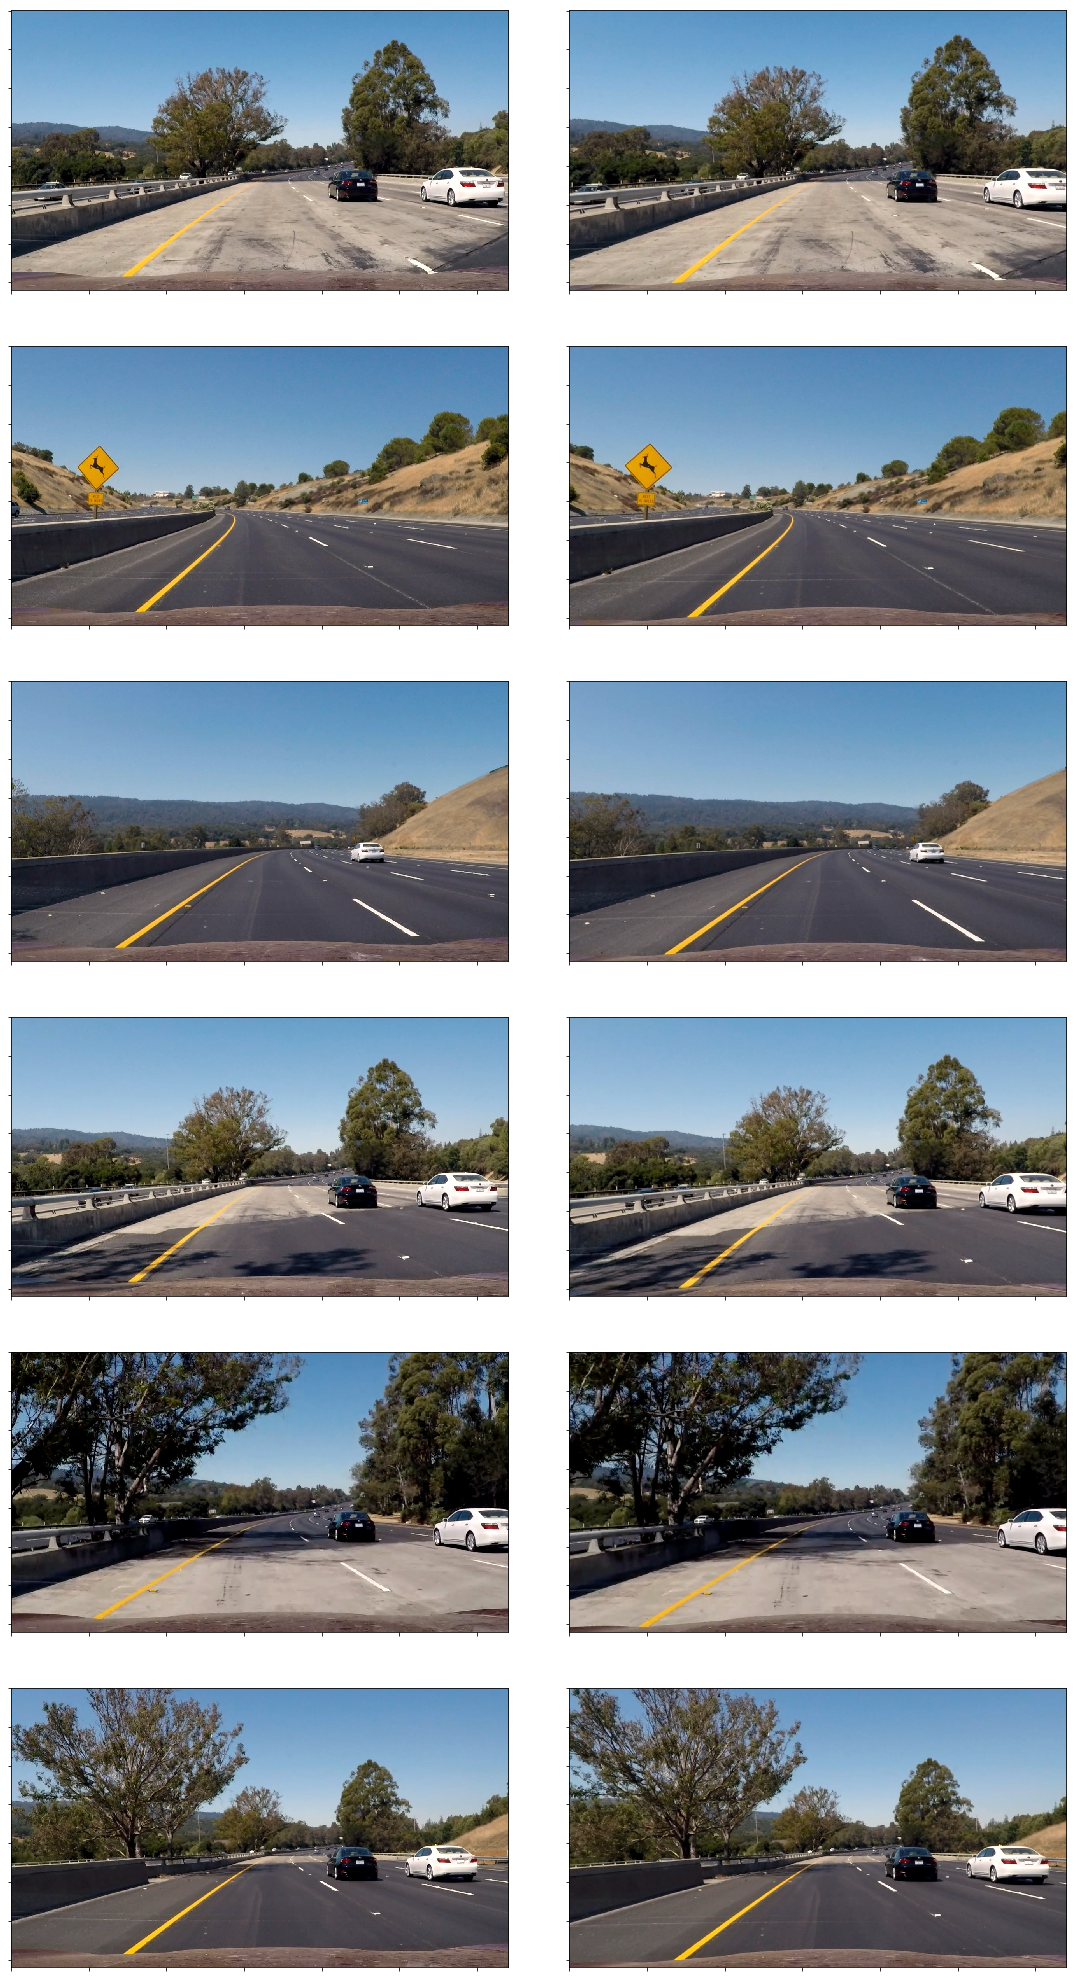

In [8]:
cal_images=glob.glob('test_images/test*.jpg')
normal_images=[]
undis_images=[]
for i in cal_images:
    img=cv2.imread(i)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    undis_images.append(cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx))
    
ShowGrid(normal_images,undis_images)

# Color and gradient threshold

---

In [9]:
def hls_color_thresh(img, thresh_Low, tresh_High):
    imgHSV=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary=np.zeros((img.shape[0], img.shape[1]))
    binary[(imgHSV[:,:,0] >= thresh_Low[0]) & (imgHSV[:,:,0] <= tresh_High[0])  &
                  (imgHSV[:,:,1] >= thresh_Low[1]) & (imgHSV[:,:,1] <= tresh_High[1])  & 
                  (imgHSV[:,:,2] >= thresh_Low[2]) & (imgHSV[:,:,2] <= tresh_High[2])]=1
                 
    return binary

def sobel_x(img, sobel_kernel=3,min_thres=20, max_thres =100):
    imghsl=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx1=cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2=cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    scl_sobelx1=np.uint8(255*sobelx1/ np.max(sobelx1))
    scl_sobelx2=np.uint8(255*sobelx2/ np.max(sobelx2))
    binaryx1=np.zeros_like(scl_sobelx1)
    binaryx1[(scl_sobelx1 >= min_thres) & (scl_sobelx1 <= max_thres)]=1
    binaryx2=np.zeros_like(scl_sobelx2)
    binaryx2[(scl_sobelx2 >= min_thres) & (scl_sobelx2 <= max_thres)]=1
    binary=np.zeros_like(scl_sobelx1)
    binary[(binaryx1 ==1) | (binaryx2 ==1)]=1
    
    return binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    

    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    gradmag=np.sqrt(sobelx**2+sobely**2)
    scl_sobel=np.uint8(255*gradmag / np.max(gradmag))
    binary=np.zeros_like(scl_sobel)
    binary[(scl_sobel >= mag_thresh[0]) & (scl_sobel <= mag_thresh[1])]=1

    return binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    absgraddir=np.arctan2(abs_sobely, abs_sobelx) 
    binary=np.zeros_like(absgraddir)
    binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])]=1

    return binary

def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely=cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    gradmag=np.sqrt(sobelx**2+sobely**2)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    absgraddir=np.arctan2(abs_sobely, abs_sobelx) 
    scl_sobel=np.uint8(255*gradmag / np.max(gradmag))
    binary=np.zeros_like(scl_sobel)
    binary[(scl_sobel >= mag_thresh[0]) & (scl_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ]=1

    return binary

In [10]:
yellow_low=np.array([0,100,100])
yellow_high=np.array([50,255,255])
white_low=np.array([18,0,180])
white_high=np.array([255,80,255])

def test_Color_Thres(white_low):
    white_low=hex_to_rgb(white_low)
    print(white_low)
    yellow_low=np.array([0,100,100])
    yellow_high=np.array([50,255,255])
    white_high=np.array([255,80,255])
    img=cv2.imread("test_images/test2.jpg")

    imgRGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    imgThres_yellow=hls_color_thresh(imgRGB,yellow_low,yellow_high)
    imgThres_white=hls_color_thresh(imgRGB,white_low,white_high)


    imgThres_both =np.zeros_like(imgThres_yellow)

    imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1

    plt.figure(figsize=(20,10))

    gs1=gridspec.GridSpec(2,2)
    gs1.update(wspace=0.02, hspace=0.02)
    ax1=plt.subplot(gs1[0])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgThres_yellow,cmap ='gray')
    
    ax1=plt.subplot(gs1[1])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgThres_white,cmap ='gray')
    
    ax1=plt.subplot(gs1[2])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgThres_both,cmap ='gray')
    
    ax1=plt.subplot(gs1[3])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.imshow(imgRGB)

In [11]:
def hex_to_rgb(hex_string):
    rgb=colors.hex2color(hex_string)
    return np.array(tuple([int(255*x) for x in rgb]))

### Widget to easily select best color

[ 18   0 180]


<function __main__.test_Color_Thres>

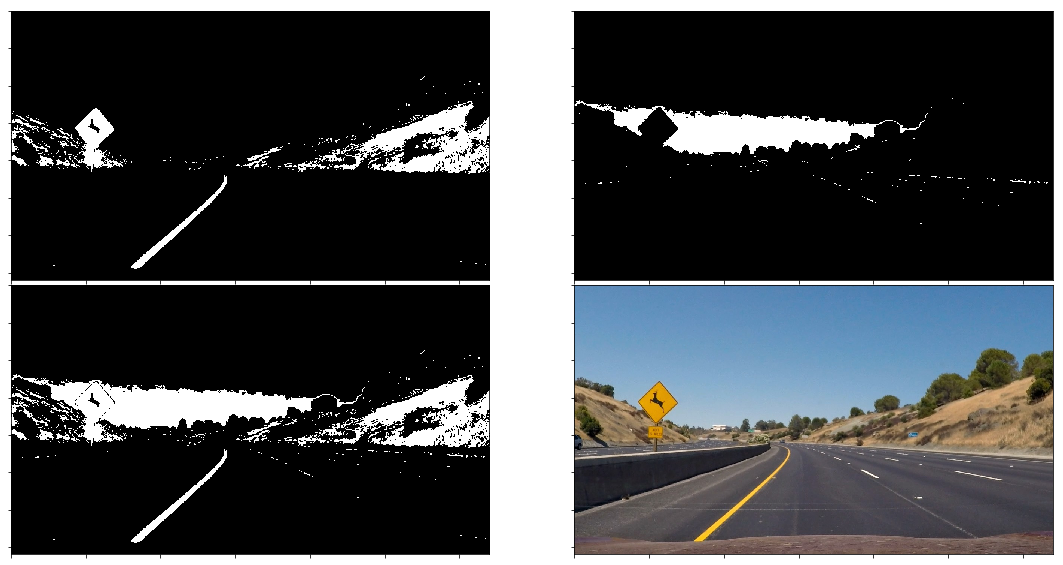

In [12]:
w_low=widgets.ColorPicker(
    description='White Low',concise=False,value='#1200b4'
)

interact(test_Color_Thres,white_low=w_low)

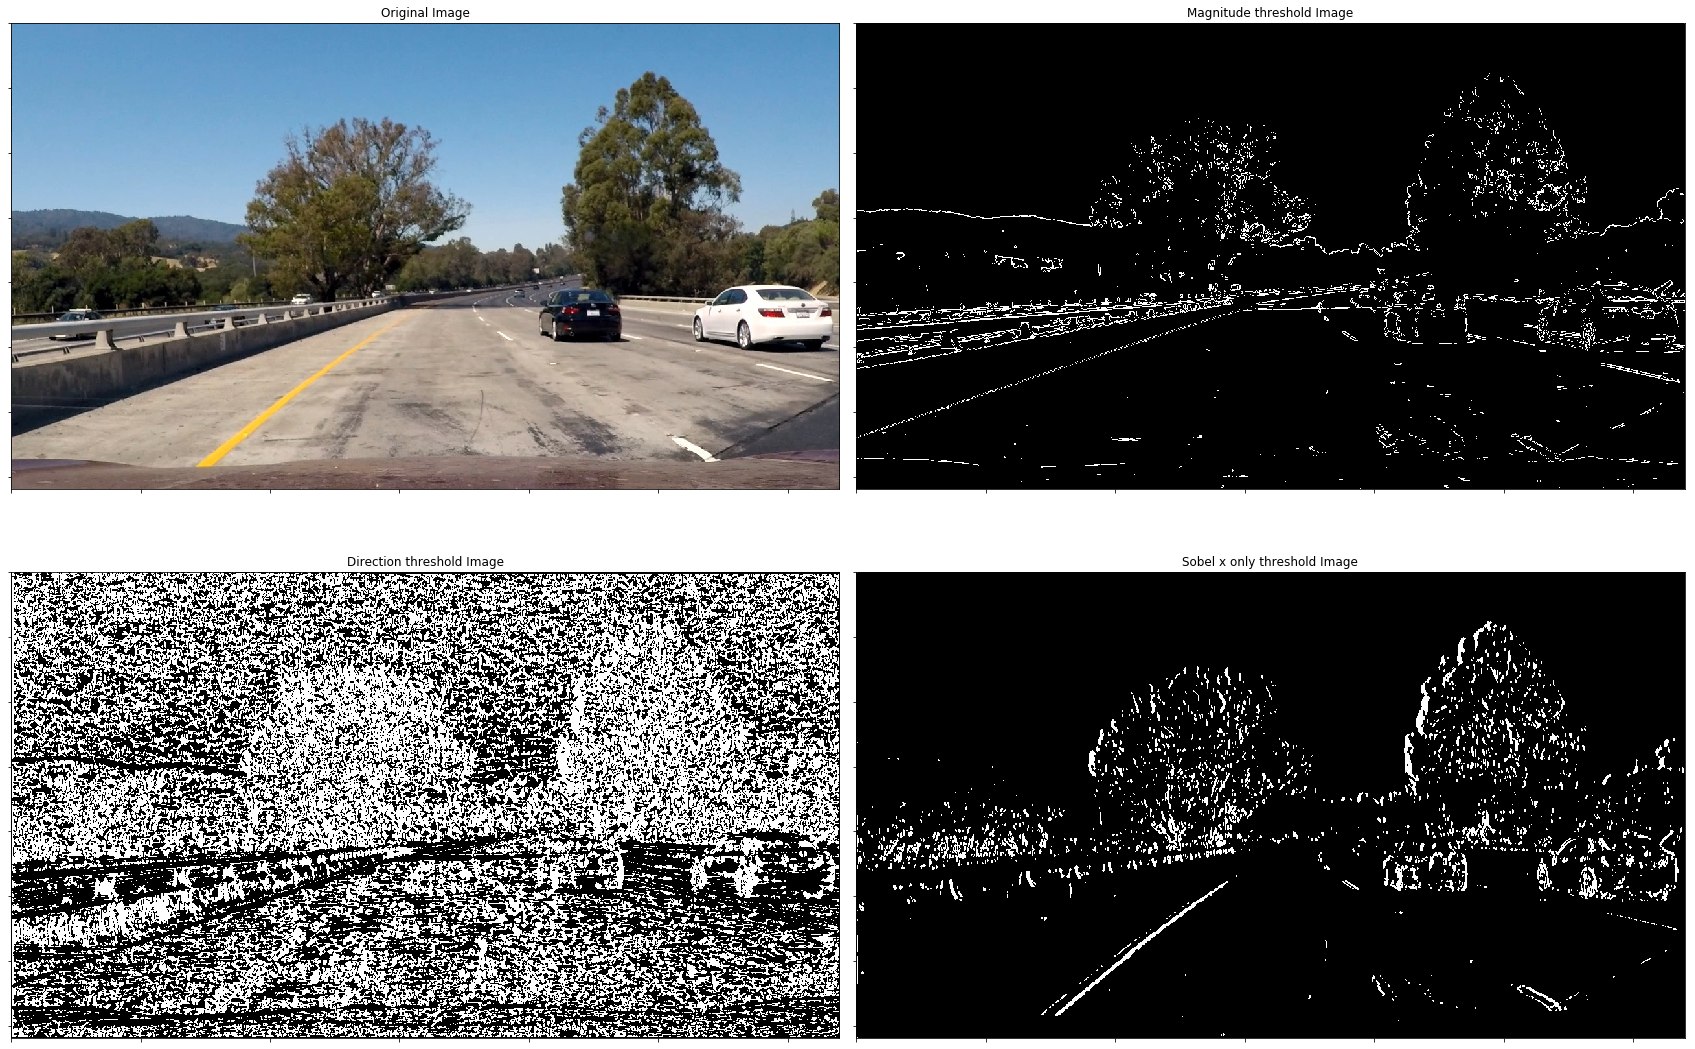

In [13]:
img=cv2.imread("test_images/test1.jpg")
imgRGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

magThr =mag_thresh(imgRGB, 3, (50, 100))
dirThr =dir_threshold(imgRGB, 9,(np.pi/240/90, np.pi/2*60/90))
imgThr=sobel_x(imgRGB,9,80,220) 

plt.figure(figsize=(30,20))
gs1=gridspec.GridSpec(2,2)
gs1.update(wspace=0.02, hspace=0.02)
ax1=plt.subplot(gs1[0])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Original Image')
plt.imshow(imgRGB)

ax1=plt.subplot(gs1[1])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Magnitude threshold Image')
plt.imshow(magThr,cmap='gray')

ax1=plt.subplot(gs1[2])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Direction threshold Image')
plt.imshow(dirThr,cmap='gray')

ax1=plt.subplot(gs1[3])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Sobel x only threshold Image')
plt.imshow(imgThr,cmap='gray')

# Perspective Transformation
---

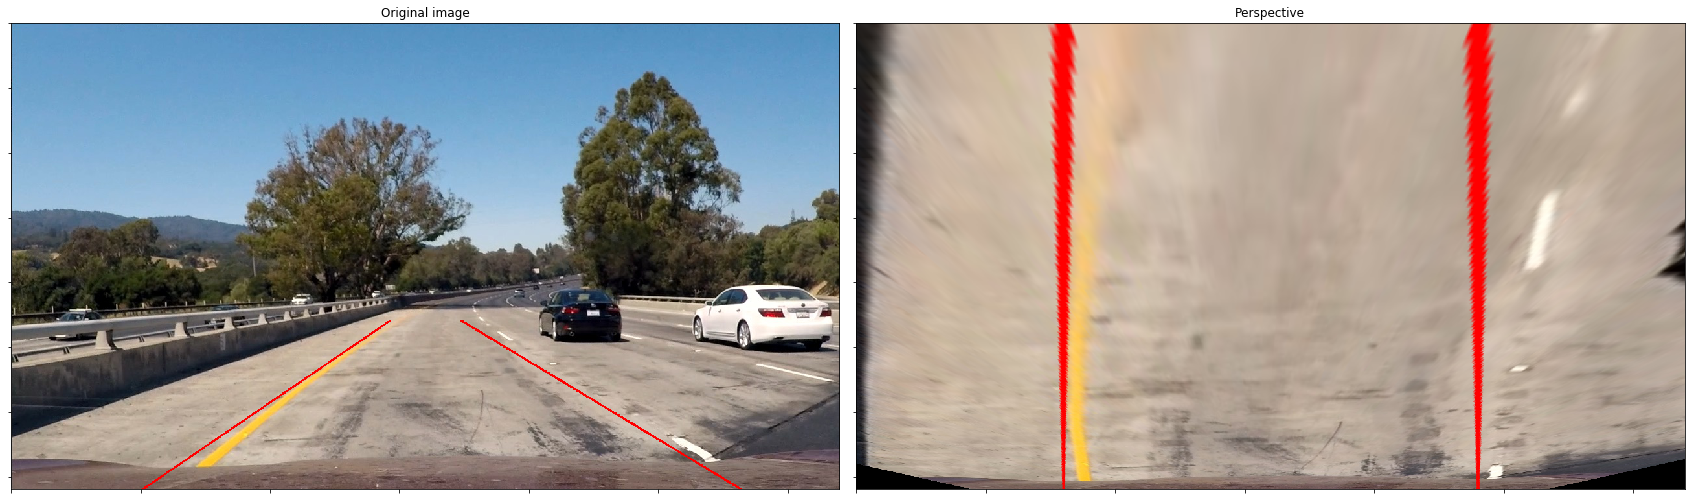

In [20]:
img_size=(imgThr.shape[1], imgThr.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


src=np.rint(src)
dst=np.rint(dst)

M_persp=cv2.getPerspectiveTransform(src, dst)
Minv_persp=cv2.getPerspectiveTransform(dst, src)

img_line=cv2.line(imgRGB,(src[0,0],src[0,1]),(src[1,0],src[1,1]),(255,0,0),2)
img_line=cv2.line(img_line,(src[2,0],src[2,1]),(src[3,0],src[3,1]),(255,0,0),2)

perspective=cv2.warpPerspective(img_line, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(30,20))

gs1=gridspec.GridSpec(1,2)
gs1.update(wspace=0.02, hspace=0.02)
ax1=plt.subplot(gs1[0])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Original image')
plt.imshow(img_line, cmap='gray')


ax1=plt.subplot(gs1[1])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Perspective')
plt.imshow(perspective, cmap='gray')

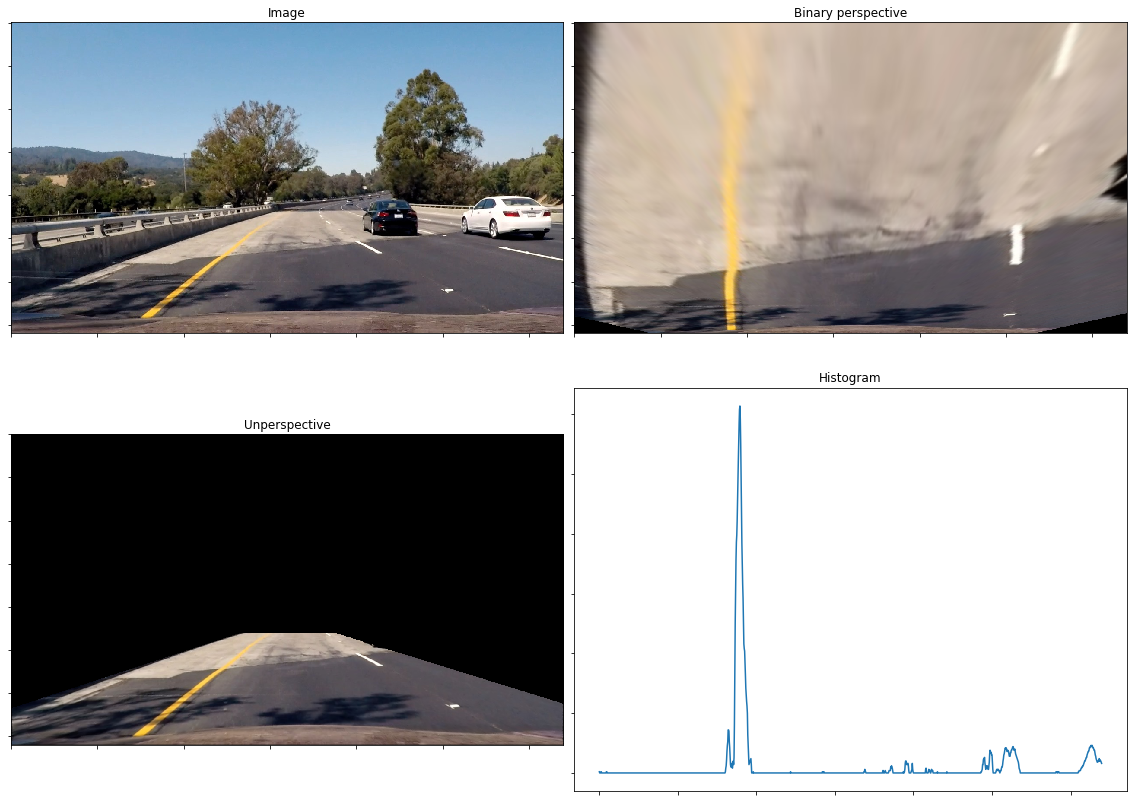

In [21]:
img=cv2.imread("test_images/test4.jpg")
imgRGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2=cv2.undistort(imgRGB, cam_mtx, cam_dist, None, cam_mtx)
img_size=img2.shape[1::-1]
RGB_warped=cv2.warpPerspective(img2, M_persp, img_size, flags=cv2.INTER_LINEAR)
img_unpersp=cv2.warpPerspective(RGB_warped, Minv_persp, img_size, flags=cv2.INTER_LINEAR)
binary_warped=cv2.warpPerspective(imgThr, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(20,15))
gs1=gridspec.GridSpec(2,2)
gs1.update(wspace=0.02, hspace=0.02)
ax1=plt.subplot(gs1[0])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Image')
plt.imshow(imgRGB)
ax1=plt.subplot(gs1[1])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Binary perspective')
plt.imshow(RGB_warped)


ax1=plt.subplot(gs1[2])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Unperspective')
plt.imshow(img_unpersp)

ax1=plt.subplot(gs1[3])
plt.axis('on')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.title('Histogram')

histogram=np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

Left base:  358
Right base: 1252


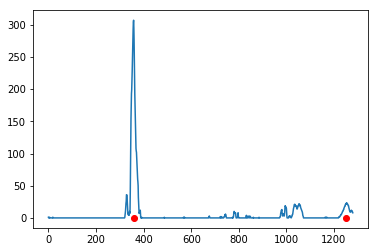

In [22]:
out_img=np.dstack((binary_warped, binary_warped, binary_warped))*255

mid=np.int(histogram.shape[0]/2)
left_base=np.argmax(histogram[:mid])
right_base=np.argmax(histogram[mid:])+mid

print("Left base: ",left_base)
print("Right base:",right_base)

plt.plot(histogram)
plt.plot([left_base,right_base], [0,0], 'ro')

In [23]:
def fitlines(binary_warped):
    histogram=np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img=np.dstack((binary_warped, binary_warped, binary_warped))*255
    mid=np.int(histogram.shape[0]/2)
    left_base=np.argmax(histogram[:mid])
    right_base=np.argmax(histogram[mid:])+mid
    nwindows=9
    window_height=np.int(binary_warped.shape[0]/nwindows)
    nonzero=binary_warped.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    leftx_current=left_base
    rightx_current=right_base
    margin=100
    minpix=50
    left_lane_inds=[]
    right_lane_inds=[]

    for window in range(nwindows):
        win_y_low=binary_warped.shape[0]-(window+1)*window_height
        win_y_high=binary_warped.shape[0]-window*window_height
        win_xleft_low=leftx_current-margin
        win_xleft_high=leftx_current+margin
        win_xright_low=rightx_current-margin
        win_xright_high=rightx_current+margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 2) 
        good_left_inds=((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds=((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:  leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: rightx_current=np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds=np.concatenate(left_lane_inds)
    right_lane_inds=np.concatenate(right_lane_inds)

    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds] 
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds] 
    
    
    left_fit =[] if len(leftx) == 0 else np.polyfit(lefty, leftx, 2)
    right_fit =[] if len(rightx) == 0 else np.polyfit(righty, rightx, 2)
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]]=[255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]]=[0, 0, 255]


    return left_fit, right_fit,out_img

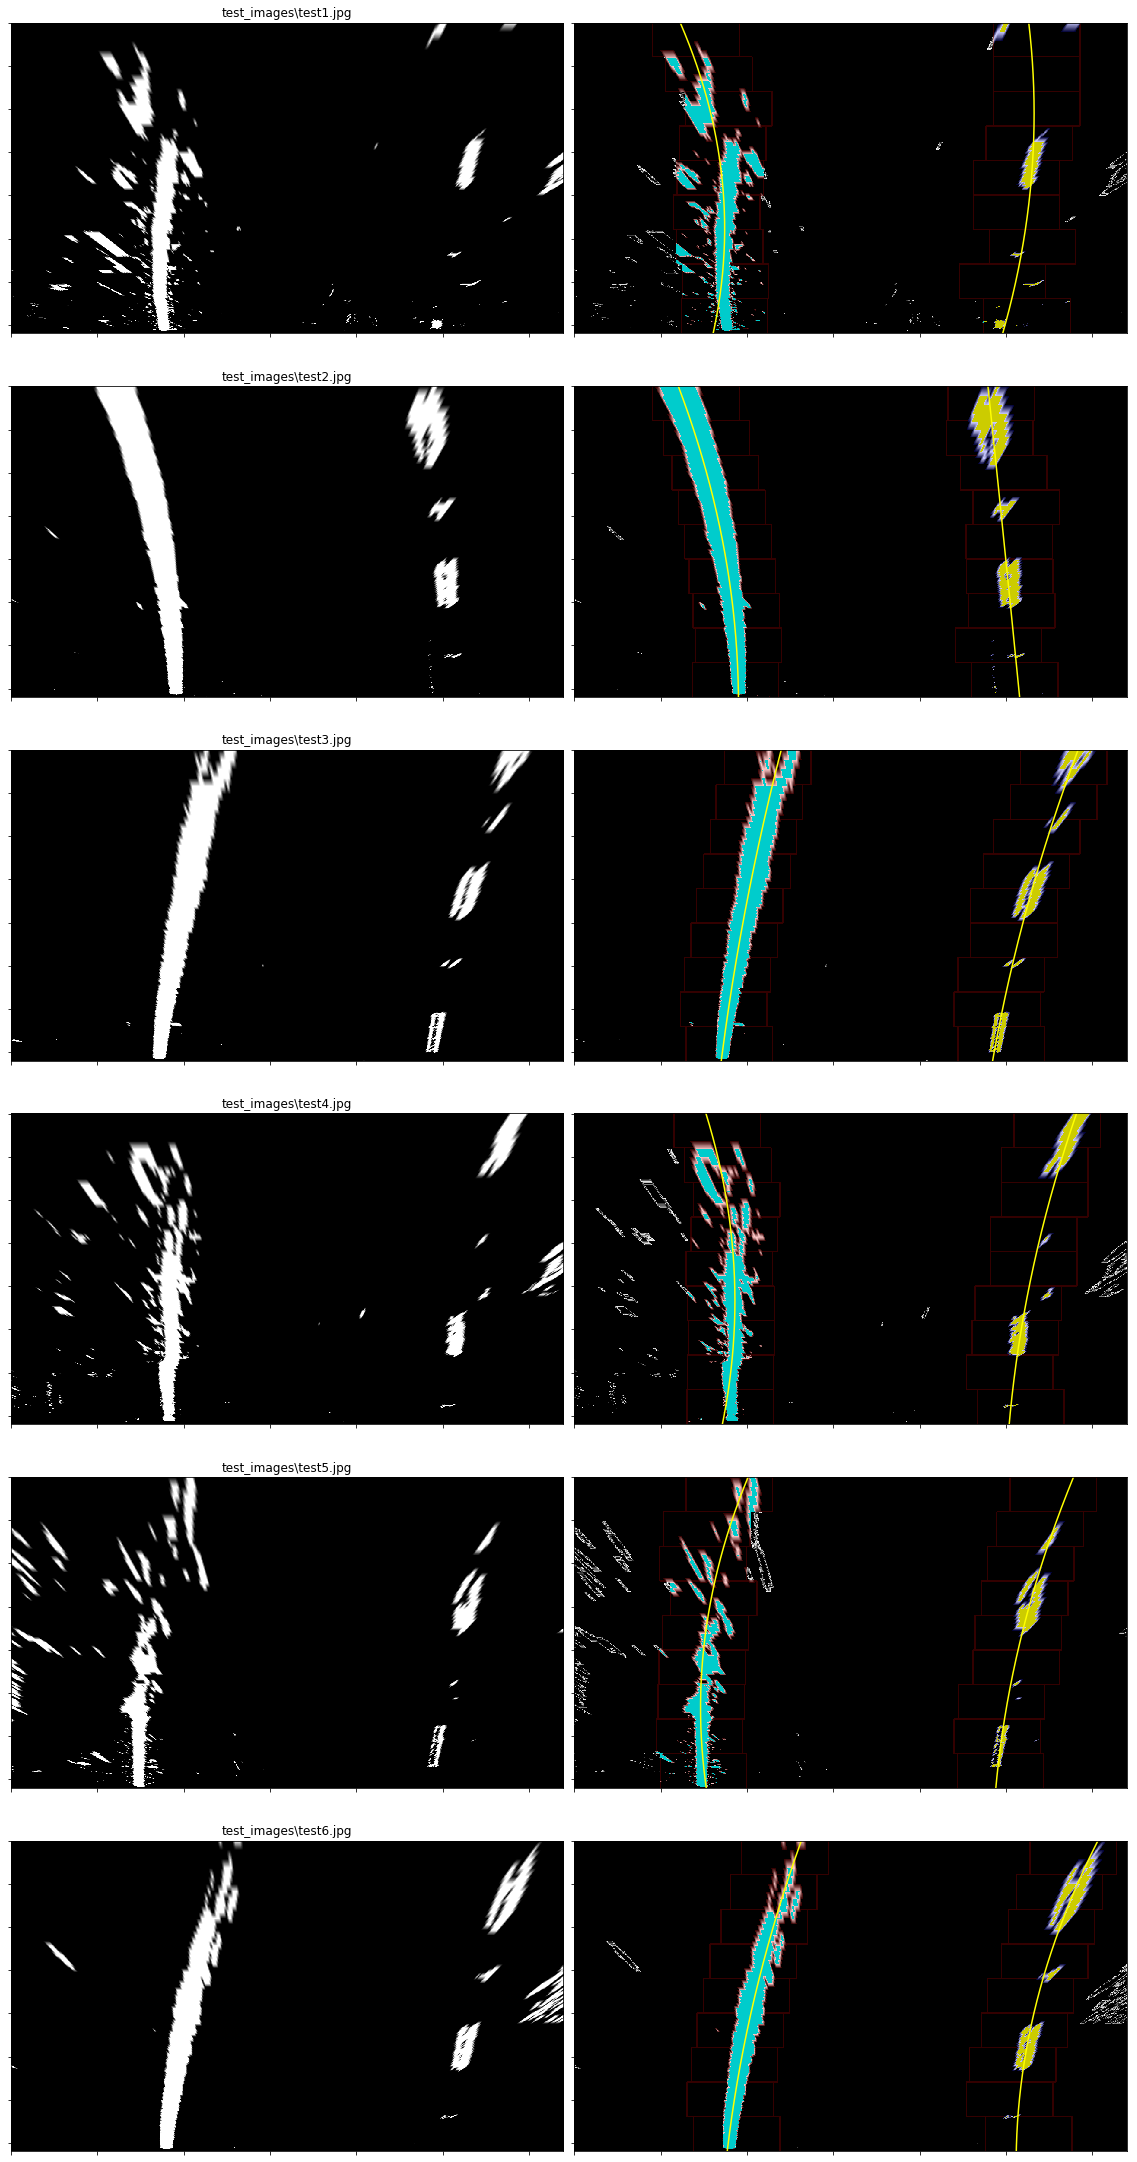

In [27]:
cal_images=glob.glob('test_images/test*.jpg')

global ref_left 
global ref_right
global left_fit
global right_fit
gs1=gridspec.GridSpec(6,2)
plt.figure(figsize=(20,40))
gs1.update(wspace=0.02, hspace=0.02)
count=0

for i in cal_images:
    img=cv2.imread(i)
    imgRGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_undist=cv2.undistort(imgRGB, cam_mtx, cam_dist, None, cam_mtx)
    imgThres_yellow=hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white=hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx=sobel_x(img_undist,9,80,220)

    img_mag_thr =np.zeros_like(imgThres_yellow)
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1)] =1

    img_size=(img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped=cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit,out_img=fitlines(binary_warped)

    ploty=np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]

    ax1=plt.subplot(gs1[count])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    plt.title(i)
    plt.imshow(binary_warped, cmap='gray')
    count+=1
    
    ax1=plt.subplot(gs1[count])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    binary_warped2=np.zeros((img_size[1], img_size[0],3))
    binary_warped2[:,:,0]=binary_warped
    binary_warped2[:,:,1]=binary_warped
    binary_warped2[:,:,2]=binary_warped
    plt.imshow(out_img)
    result=cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
    plt.imshow(result)
    count+=1

In [28]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero=binary_warped.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    margin=100
    left_lane_inds=((nonzerox > (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]-margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]+margin))) 
    right_lane_inds=((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]-margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]+margin)))  

    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds] 
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds]
    
    left_fit_updated =[] if len(leftx) == 0 else np.polyfit(lefty, leftx, 2)
    right_fit_updated =[] if len(rightx) == 0 else np.polyfit(righty, rightx, 2)
    
    return  left_fit_updated, right_fit_updated

In [29]:
def curvature(left_fit, right_fit, binary_warped):
    ploty=np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval=np.max(ploty)
    
    ym_per_pix=30/img_size[0] 
    xm_per_pix=3.7/700 

    left_curverad=((1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad=((1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center=(((left_fit[0]*img_size[0]**2+left_fit[1]*img_size[0]+left_fit[2]) +(right_fit[0]*img_size[0]**2+right_fit[1]*img_size[0]+right_fit[2]) ) /2-640)*xm_per_pix
    
    return left_curverad, right_curverad, center

In [30]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    xm_per_pix=3.7/700 
    if len(left_fit) ==0 or len(right_fit) == 0:
        status=False
        d0=0
        d1=0
    else:
        L_0=2*left_fit[0]*460+left_fit[1]
        R_0=2*right_fit[0]*460+right_fit[1]
        d0= np.abs(L_0-R_0)

        L_1=2*left_fit[0]*img_size[0]+left_fit[1]
        R_1=2*right_fit[0]*img_size[0]+right_fit[1]
        d1= np.abs(L_1-R_1)

        
        status=True if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope else False
    
    return(status, d0, d1)

In [31]:
def cool_visualization(center_data,graph,margin):
    maxlen=55
    if len(center_data)>maxlen:
        center_data.pop(0)
    pts=center_data
    for i in range(1, len(center_data)):
        if center_data[i-1] is None or center_data[i] is None:
            continue    
        if i==len(center_data)-1:
            thickness=4 
        elif i==len(center_data)-2:
            thickness=3
        else:
            thickness=2
        cv2.line(graph, (4*i-4,50-int(100*center_data[i-1])), (4*i,50-int(100*center_data[i])), (255, 0, 0), thickness)
    graph=cv2.line(graph,(0,50),(margin,50),(255,255,0),2)    
    return graph

## All together

---

In [38]:
global counter
global center_data
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   

center_data=[]

def process_image(image,yellow_low=np.array([0,100,100]),yellow_high=np.array([-0.0001,0,1000]),
                  white_low=np.array([-0.0001,0,400]),white_high=np.array([-0.0001,0,1000])   ,
                  sobel_kernel=9,min_thres=80, max_thres =220,min_slope=0,max_slope=.5):

    img_undist=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    global counter
    global center_data
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow=hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white=hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx=sobel_x(img_undist,sobel_kernel,min_thres ,max_thres) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    img_size=(img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped=cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    if counter==0:
        left_fit, right_fit,out_imgfit=fitlines(binary_warped)
    else:
        left_fit, right_fit=fit_continuous(left_fit, right_fit, binary_warped)
    
    
    
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, min_slope, max_slope)
    
    if status_sanity  == True:        
        ref_left,ref_right=left_fit,right_fit        
        counter+=1
    else:     
        left_fit,right_fit=ref_left,ref_right
        
    left_curv, right_curv, center_off=curvature(left_fit, right_fit, binary_warped)
    color=(255,255, 255)
    warp_zero=np.zeros_like(binary_warped).astype(np.uint8)
    color_warp=np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty=np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0] )
    left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left=np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts=np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), color)
    newwarp=cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 
    result=cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    img_merge= result
    img_birds=color_warp

    margin=300
    top_margin=50
    h=300
    img_out=np.zeros((img_size[1],img_size[0],3), dtype=np.uint8)
    
    graph=np.zeros((100,margin,3),dtype=np.uint8)

    center_data.append(center_off)
    graph=cool_visualization(center_data,graph,margin)

    img_out[img_size[1]-h-100:img_size[1]-h,img_size[0]-margin:img_size[0], :] =graph
    img_out[top_margin:img_size[1],0:img_size[0]-margin,0:3] =cv2.resize(img_merge,(img_size[0]-margin,img_size[1]-top_margin))    
    img_out[img_size[1]-h:img_size[1],img_size[0]-margin:img_size[0], 0] =cv2.resize(img_mag_thr*255,(margin,h))
    img_out[img_size[1]-h:img_size[1],img_size[0]-margin:img_size[0], 1] =cv2.resize(img_mag_thr*255,(margin,h))
    img_out[img_size[1]-h:img_size[1],img_size[0]-margin:img_size[0], 2] =cv2.resize(img_mag_thr*255,(margin,h))

    TextL="-Left curvature: "+str(int(left_curv))+" m"
    TextR="-Right curvature: "+str(int(right_curv))+ " m"
    TextC="-Center offset: "+str(round( center_off,2))+"m"
    TextUp="-Updating: "+str(status_sanity)
    TextCent= "-Center_data size: "+str(len(center_data))
    fontScale=.5
    thickness=1
    
    fontFace=cv2.FONT_HERSHEY_TRIPLEX

    cv2.putText(img_out, "DATA", (img_size[0]-margin+100,60), fontFace, .8,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextL, (img_size[0]-margin+20,100), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextR, (img_size[0]-margin+20,130), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextC, (img_size[0]-margin+20,160), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextUp, (img_size[0]-margin+20,190), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, "Center offset history", (img_size[0]-margin+70,300), fontFace, .4,(255,255,255), thickness,  lineType=cv2.LINE_AA)

    cv2.putText(img_out, "Lucas Gago                              SDCND P4                              v0.8", (5,30), fontFace, .7,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    
    return img_out

## Results
---

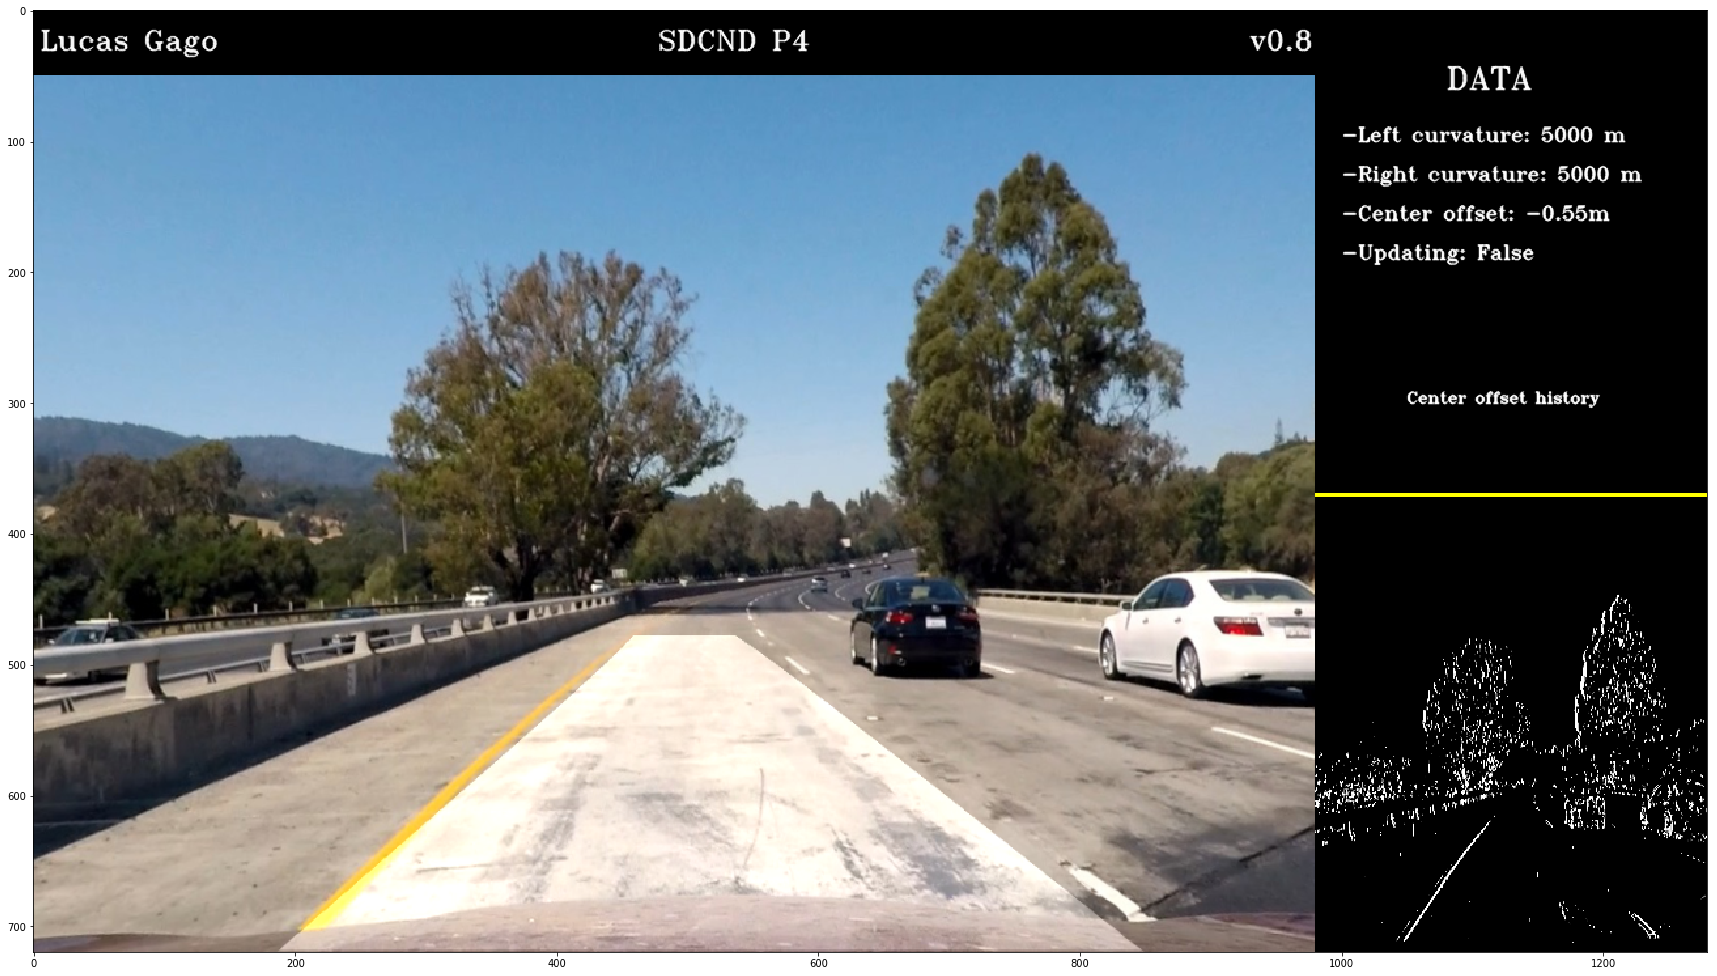

In [39]:
img=cv2.imread("test_images/test1.jpg")
imgRGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2= process_image(imgRGB)
plt.figure(figsize=(30,20))
plt.imshow(img2)


In [ ]:
#Create video file pipeline
output='out_project_video.mp4'
clip1=VideoFileClip("project_video.mp4")
out_clip=clip1.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)
print(counter)

In [40]:
output='out_project_video.mp4'
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))